# Polynomial Linear Regression

Haytham Mohamed - INFS 890 - Spring 2020

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

In [24]:
# 1- read data file
# 1- read processed file
file_dir = '../data/processed-data/'

non_normalized_data_file = 'missing_outliers_processed_dataset.csv'
normalized_data_file = 'normalized_dataset.csv'
factored_data_file = 'factored_dataset.csv'

data = pd.read_csv(file_dir + normalized_data_file)

In [25]:
data.head(5)

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
0,0.332,0.557,0.332,0.325,0.037,16.982,1.591,3.206,0.002,0.012,7.000,0.980
1,0.400,0.616,0.300,0.351,0.047,20.583,1.608,3.552,0.003,0.019,7.000,1.620
2,0.469,0.608,0.316,0.362,0.039,19.448,1.390,3.586,0.003,0.024,7.000,2.180
3,0.490,0.624,0.300,0.362,0.108,17.319,1.730,3.512,0.003,0.022,6.000,2.130
4,0.500,0.608,0.316,0.374,0.133,16.650,1.917,3.449,0.003,0.023,3.000,2.220


## Polynomial Linear Regression Model

In [26]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=0.2, random_state=365)

# for better convergence and result scale target to values between 0 - 1
maxltcy = targets.max()
y_train = y_train / maxltcy
y_test = y_test / maxltcy


In [27]:
# standardize the features
scaler = StandardScaler()

# using SelectFromModel metatransformer to select features
clf = LassoCV()
sfm = SelectFromModel(clf, threshold=0.01)

# regression model
reg = LinearRegression(fit_intercept=False)
poly = PolynomialFeatures(degree=2, interaction_only=True)

pline = Pipeline([
    ('scaler', scaler),
    ('feature_selection', sfm),
    ('poly', poly),
    ('regression', reg)
])

pline = pline.fit(x_train, y_train)

print ("Done..!")

Done..!


In [28]:
y_hat = pline.predict(x_train)

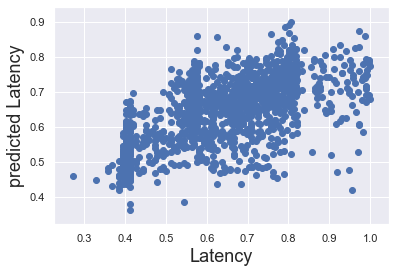

In [29]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

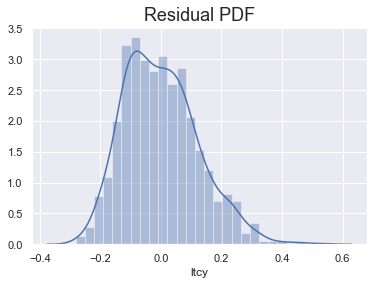

In [30]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [31]:
# R-Squared
pline.score(x_train, y_train)

0.39322945698603484

In [32]:
pline.named_steps.regression.intercept_

0.0

In [33]:
pline.named_steps.regression.coef_

array([ 0.6349875 , -0.01679331,  0.03035426, -0.08967757, -0.0111181 ,
        0.18512225, -0.00149223, -0.00505145, -0.00872972,  0.02237551,
       -0.0655108 , -0.00692927,  0.04882785,  0.03954287, -0.00167399,
       -0.0412577 ])

In [34]:
selector = pline.named_steps.feature_selection
#selected_features = selector.transform(inputs)
number_of_features = pline.named_steps.regression.coef_.reshape(-1,1).shape[0]

features = []
for i in range(number_of_features):
    features.append('Feature_' + str(i))

reg_summary = pd.DataFrame(features, columns=['features'])
reg_summary['weights'] = pline.named_steps.regression.coef_
reg_summary

,features,weights
0,Feature_0,0.635
1,Feature_1,-0.017
2,Feature_2,0.030
3,Feature_3,-0.090
4,Feature_4,-0.011
...,...,...
11,Feature_11,-0.007
12,Feature_12,0.049
13,Feature_13,0.040
14,Feature_14,-0.002


In [35]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Model Result (mean and std of error): %.2f (%.2f) MSE" % (mean_error, std_error))

Model Result (mean and std of error): 0.10 (0.07) MSE


### Testing

In [36]:
y_hat_test = pline.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

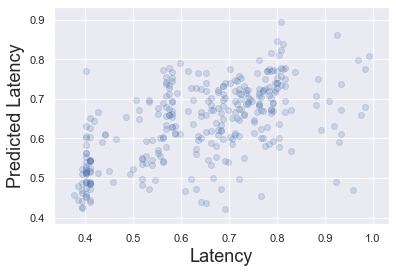

In [37]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [38]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.973,1.767
1,1.935,1.778
2,1.732,1.682
3,2.177,2.266
4,2.205,1.819


In [39]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.973,1.767,0.205,11.607
1,1.935,1.778,0.158,8.864
2,1.732,1.682,0.050,2.966
3,2.177,2.266,-0.089,3.929
4,2.205,1.819,0.385,21.186
...,...,...,...,...
312,2.241,2.700,-0.459,16.985
313,2.151,2.134,0.017,0.790
314,2.079,2.266,-0.187,8.247
315,1.890,2.238,-0.348,15.554


In [40]:
perf.describe()

,prediction,target,residual,difference%
count,317.000,317.000,317.000,317.000
mean,1.900,1.921,-0.020,9.602
std,0.187,0.292,0.240,7.325
min,1.525,1.457,-1.009,0.057
25%,1.744,1.704,-0.148,3.929
50%,1.925,1.940,0.014,7.661
75%,2.045,2.143,0.142,14.019
max,2.443,2.700,0.664,44.357


In [41]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
145,2.08,2.08,0.00,0.06
40,1.74,1.75,-0.00,0.10
94,1.97,1.97,-0.00,0.10
81,1.96,1.95,0.01,0.28
308,2.07,2.06,0.01,0.39
154,2.25,2.24,0.01,0.56
166,2.04,2.06,-0.01,0.59
153,1.73,1.71,0.01,0.67
184,1.70,1.71,-0.01,0.70
10,1.98,1.99,-0.01,0.71


# Prediction Accuracy

In [42]:
# validation mean_absolute_percentage_error (MAPE)
test_error = np.absolute(perf['residual'] / perf['target'])
mean_error = np.mean(test_error)
min_error = np.min(test_error)
max_error = np.max(test_error)
std_error = np.std(test_error)

print("Mean Absolute Percentate Error std of error (MAPE): [mean: %.2f std: %.2f max: %.2f min: %.2f]" \
      % (mean_error, std_error, max_error, min_error))


Mean Absolute Percentate Error std of error (MAPE): [mean: 0.10 std: 0.07 max: 0.44 min: 0.00]


In [43]:
# validation mean_squared_error  (MSE)
test_error =  np.power(perf['residual'] , 2)
mean_error = np.mean(test_error)
min_error = np.min(test_error)
max_error = np.max(test_error)
std_error = np.std(test_error)

print("Mean Squared Error (MSE): [mean: %.2f std: %.2f max: %.2f min: %.2f]" \
      % (mean_error, std_error, max_error, min_error))


Mean Squared Error (MSE): [mean: 0.06 std: 0.11 max: 1.02 min: 0.00]


R2 is a statistic that will give some information about the goodness of fit of a model. In regression, the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data.

In [44]:
# R-Squared 
# = 1 -  ( sum of squared residual  / sum of squared variance )
# sum of variance squared = sum (( y - y-mean ) ** 2)
# sum of residual squared = sum (( y-hat - y-mean ) ** 2)
# where y is the observed target, y-mean is the mean of observed target, y-hat is a predicted value

y_mean = np.mean(targets)
sum_squared_residual = np.sum(np.power(perf['residual'] , 2))
sum_squared_variance = np.sum(np.power(targets - y_mean , 2))

R_squared = 1 - ( sum_squared_residual / sum_squared_variance )

R_squared


0.6815316563196869